# 使用 Naive Bayes 技術，收集各國股市前日收盤漲跌情形進行台灣股市漲跌的預測

因為時間區域不同，各國股市收盤時間是不一樣的，但會有連動的影響，我們可以根據過去歷史紀錄，分析國際股市的連動關聯性並建構談灣股市當日的漲跌狀態，換句話說，可以使用其國家前一日或是當日正在進行的股市漲跌情形來預測台灣股市當日的股票漲跌的趨勢。


In [1]:
pip install -r requirements.txt

  Stored in directory: C:\Users\TWP\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import pytz   #使用 pytz 處理 Python的時區問題
import yfinance as yf #Yahoo! Finance's API

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

## yfinance: Download market data from Yahoo! Finance's API

yfinance is not affiliated, endorsed, or vetted by Yahoo, Inc. It's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes.

https://github.com/ranaroussi/yfinance

參考連結 Yahoo! Finance Global Indices：https://finance.yahoo.com/world-indices  
參考連結 Apple Inc. (AAPL) https://finance.yahoo.com/quote/AAPL?p=AAPL&.tsrc=fin-srch

In [12]:
# Example of downloading APPle Inc. historical stock data
aapl_df = yf.download('AAPL', 
                      start='2021-01-01', 
                      end='2022-05-16', 
                      progress=False,
)
aapl_df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-02,156.710007,158.229996,153.270004,157.960007,157.728256,123055300
2022-05-03,158.149994,160.710007,156.320007,159.479996,159.246017,88966500
2022-05-04,159.669998,166.479996,159.259995,166.020004,165.776428,108256500
2022-05-05,163.850006,164.080002,154.949997,156.770004,156.540009,130525300
2022-05-06,156.009995,159.440002,154.179993,157.279999,157.279999,116055700
2022-05-09,154.929993,155.830002,151.490005,152.059998,152.059998,131577900
2022-05-10,155.520004,156.740005,152.929993,154.509995,154.509995,115366700
2022-05-11,153.500000,155.449997,145.809998,146.500000,146.500000,142689800
2022-05-12,142.770004,146.199997,138.800003,142.559998,142.559998,182602000


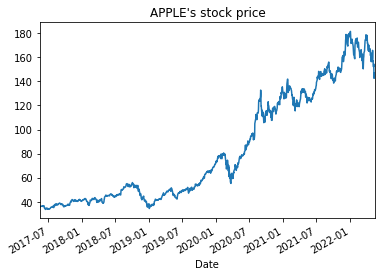

In [13]:
# Example for ploting Apple stock trend in 5 years
ticker = yf.Ticker('AAPL')
aapl_df = ticker.history(period="5y")
aapl_df['Close'].plot(title="APPLE's stock price")

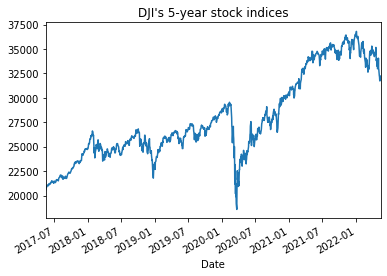

In [38]:
# ^DJI is the symbol of Dow Jones Industrial Average in Yahoo! Finance
tickerData = yf.Ticker('^DJI')
DJI_df_5y = tickerData.history(period="5y")
DJI_df_5y['Close'].plot(title="DJI's 5-year stock indices")

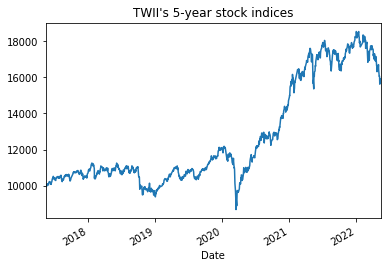

In [41]:
# ^TWII is the symbol of Taiwan Stock in Yahoo! Finance
tickerData = yf.Ticker('^TWII')
TWII = tickerData.history(period="5y")
TWII['Close'].plot(title="TWII's 5-year stock indices")

In [42]:
twii = yf.Ticker('^TWII')
twii.info

{'exchange': 'TAI',
 'shortName': 'TSEC weighted index',
 'exchangeTimezoneName': 'Asia/Taipei',
 'exchangeTimezoneShortName': 'CST',
 'isEsgPopulated': False,
 'gmtOffSetMilliseconds': '28800000',
 'quoteType': 'INDEX',
 'symbol': '^TWII',
 'messageBoardId': 'finmb_INDEXTWII',
 'market': 'tw_market',
 'previousClose': 15832.54,
 'regularMarketOpen': 15943.69,
 'twoHundredDayAverage': 17391.918,
 'trailingAnnualDividendYield': None,
 'payoutRatio': None,
 'volume24Hr': None,
 'regularMarketDayHigh': 16032.85,
 'navPrice': None,
 'averageDailyVolume10Day': 3233310,
 'totalAssets': None,
 'regularMarketPreviousClose': 15832.54,
 'fiftyDayAverage': 17054.65,
 'trailingAnnualDividendRate': None,
 'open': 15943.69,
 'toCurrency': None,
 'averageVolume10days': 3233310,
 'expireDate': None,
 'yield': None,
 'algorithm': None,
 'dividendRate': None,
 'exDividendDate': None,
 'beta': None,
 'circulatingSupply': None,
 'startDate': None,
 'regularMarketDayLow': 15847.46,
 'priceHint': 2,
 'curre

In [43]:
twii.info['exchangeTimezoneName']

'Asia/Taipei'

## 讀入股市資料並進行資料清理

讀取國際股市漲跌資料及資料清理的詳細資訊請參考前一次實習內容


In [44]:
def read(
    symbol: str,
    period: str = '1y',
    interval: str = '1d',
) -> pd.Series:
    ticker = yf.Ticker(symbol)
    history = ticker.history(period=period, interval=interval)

    # attach timezone information on dates
    tz = pytz.timezone(ticker.info['exchangeTimezoneName'])
    history.index = history.index.tz_localize(tz)

    return history['Close'].rename(symbol)

In [45]:
read('^TWII')

Date
2021-05-17 00:00:00+08:00    15353.889648
2021-05-18 00:00:00+08:00    16145.980469
2021-05-19 00:00:00+08:00    16132.660156
2021-05-20 00:00:00+08:00    16042.360352
2021-05-21 00:00:00+08:00    16302.059570
2021-05-24 00:00:00+08:00    16338.290039
2021-05-25 00:00:00+08:00    16595.669922
2021-05-26 00:00:00+08:00    16643.689453
2021-05-27 00:00:00+08:00    16601.609375
2021-05-28 00:00:00+08:00    16870.859375
2021-05-31 00:00:00+08:00    17068.429688
2021-06-01 00:00:00+08:00    17162.380859
2021-06-02 00:00:00+08:00    17165.039062
2021-06-03 00:00:00+08:00    17246.160156
2021-06-04 00:00:00+08:00    17147.410156
2021-06-07 00:00:00+08:00    17083.910156
2021-06-08 00:00:00+08:00    17076.210938
2021-06-09 00:00:00+08:00    16966.220703
2021-06-10 00:00:00+08:00    17159.220703
2021-06-11 00:00:00+08:00    17213.519531
2021-06-15 00:00:00+08:00    17371.289062
2021-06-16 00:00:00+08:00    17307.859375
2021-06-17 00:00:00+08:00    17390.609375
2021-06-18 00:00:00+08:00    

In [46]:
symbols = [
    '^AORD',
    '^AXJO',
    '^BFX',
    '^BSESN',
    '^BUK100P',
    '^BVSP',
    '^DJI',
    '^FCHI',
    '^GDAXI',
    '^GSPC',
    '^GSPTSE',
    '^HSI',
    '^JKSE',
    '^KS11',
    '^MXX',
    '^N225',
    '^NYA',
    '^NZ50',
    '^RUT',
    '^STOXX50E',
    '^TWII',
    '^XAX',
]

# takes about 5 minutes to download these 24 global indices within a year
results = []
for symbol in symbols:
    result = read(symbol, period='1y', interval='1d')

    # convert timezone into 'Asia/Taipei'
    result.index = result.index.tz_convert(pytz.timezone('Asia/Taipei'))
    # remain only date information
    result.index = result.index.date

    results.append(result)

history = pd.concat(results, axis='columns')
history

C:\Users\TWP\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,^AORD,^AXJO,^BFX,^BSESN,^BUK100P,^BVSP,^DJI,^FCHI,^GDAXI,^GSPC,...,^JKSE,^KS11,^MXX,^N225,^NYA,^NZ50,^RUT,^STOXX50E,^TWII,^XAX
2021-05-16,7255.799805,7023.600098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3134.520020,NaN,27824.830078,NaN,12410.469727,NaN,NaN,NaN,NaN
2021-05-17,7299.100098,7066.000000,4072.149902,49580.730469,701.940002,122938.000000,34327.789062,6367.350098,15396.620117,4163.290039,...,5833.859863,3173.050049,49371.980469,28406.839844,16422.960938,12428.620117,2227.120117,4006.840088,15353.889648,3210.770020
2021-05-18,7165.700195,6931.700195,4074.199951,50193.328125,702.489990,122980.000000,34060.660156,6353.669922,15386.580078,4127.830078,...,5834.394043,NaN,49789.308594,28044.449219,16337.730469,12281.500000,2210.879883,4005.340088,16145.980469,3188.989990
2021-05-19,7252.600098,7019.600098,4021.270020,49902.640625,692.679993,122636.000000,33896.039062,6262.549805,15113.559570,4115.680176,...,5760.583984,3162.280029,49382.250000,28098.250000,16233.320312,12437.169922,2193.639893,3936.739990,16132.660156,3145.439941
2021-05-20,7265.299805,7030.299805,4046.889893,49564.859375,NaN,122701.000000,34084.148438,6343.580078,15370.259766,4159.120117,...,5797.597168,3156.419922,49907.359375,28317.830078,16350.450195,12459.610352,2207.760010,3999.909912,16042.360352,3177.290039
2021-05-21,NaN,NaN,4061.189941,50540.480469,699.830017,122592.000000,34207.839844,6386.410156,15437.509766,4155.859863,...,5773.120117,NaN,49778.808594,NaN,16375.000000,NaN,2215.270020,4025.780029,16302.059570,3183.370117
2021-05-23,7276.000000,7045.899902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3144.300049,NaN,28364.609375,NaN,12449.000000,NaN,NaN,NaN,NaN
2021-05-24,7349.100098,7115.200195,4071.959961,50651.898438,NaN,124032.000000,34393.980469,6408.490234,NaN,4197.049805,...,5763.631836,3171.320068,49457.929688,28553.980469,16464.689453,12341.190430,2227.340088,NaN,16338.290039,3192.429932
2021-05-25,7331.600098,7092.500000,4067.270020,50637.531250,NaN,122988.000000,34312.460938,6390.270020,15465.089844,4188.129883,...,5815.839844,3168.429932,48826.949219,28642.189453,16390.189453,12347.440430,2205.750000,4036.040039,16595.669922,3174.070068
2021-05-26,7344.000000,7094.899902,4061.899902,51017.519531,700.330017,123989.000000,34323.050781,6391.600098,15450.719727,4195.990234,...,NaN,3165.510010,49103.500000,28549.009766,16451.960938,12243.339844,2249.270020,4031.669922,16643.689453,3200.959961


In [49]:
history.to_pickle('history.pkl.zip') #使用 Pickle 模組保存資料，壓縮資料、保存、並隨時隨地解開儲存好的資料，還原工作階段

In [50]:
history = pd.read_pickle('history.pkl.zip')

In [51]:
# shift target stock negatively for reasonable prediction
history['^TWII'] = history['^TWII'].shift(-1)

history.dropna(inplace=True)
history

,^AORD,^AXJO,^BFX,^BSESN,^BUK100P,^BVSP,^DJI,^FCHI,^GDAXI,^GSPC,...,^JKSE,^KS11,^MXX,^N225,^NYA,^NZ50,^RUT,^STOXX50E,^TWII,^XAX
2021-05-17,7299.100098,7066.000000,4072.149902,49580.730469,701.940002,122938.0,34327.789062,6367.350098,15396.620117,4163.290039,...,5833.859863,3173.050049,49371.980469,28406.839844,16422.960938,12428.620117,2227.120117,4006.840088,16145.980469,3210.770020
2021-05-27,7424.000000,7179.500000,4058.020020,51115.218750,698.890015,124367.0,34464.640625,6435.709961,15406.730469,4200.879883,...,5841.828125,3188.729980,49627.949219,29149.410156,16531.949219,12182.250000,2273.070068,4039.209961,16870.859375,3223.239990
2021-06-02,7510.700195,7260.100098,4091.820068,51849.480469,707.909973,129601.0,34600.378906,6521.520020,15602.709961,4208.120117,...,6031.578125,3247.429932,50749.640625,29058.109375,16673.960938,12429.980469,2297.830078,4088.500000,17246.160156,3281.770020
2021-06-07,7542.299805,7292.600098,4109.459961,52328.511719,705.799988,130776.0,34630.238281,6543.560059,15677.150391,4226.520020,...,6069.935059,3247.830078,51427.640625,28963.560547,16709.300781,12517.650391,2319.179932,4097.649902,17076.210938,3285.750000
2021-06-08,7522.000000,7270.200195,4107.560059,52275.570312,707.869995,129787.0,34599.820312,6551.009766,15640.599609,4227.259766,...,5999.369141,3216.179932,50865.210938,28860.800781,16685.480469,12566.500000,2343.760010,4096.009766,16966.220703,3316.399902
2021-06-09,7558.799805,7302.500000,4149.930176,51941.640625,705.770020,129907.0,34447.140625,6563.450195,15581.139648,4219.549805,...,6047.475098,3224.639893,50823.300781,28958.560547,16620.000000,12518.009766,2327.129883,4096.850098,17159.220703,3318.080078
2021-06-10,7577.200195,7312.299805,4168.359863,52300.468750,705.950012,130076.0,34466.238281,6546.490234,15571.219727,4239.180176,...,6107.538086,3249.320068,50886.328125,28948.730469,16651.429688,12550.389648,2311.409912,4096.069824,17213.519531,3320.620117
2021-06-15,7633.399902,7386.200195,4221.189941,52773.050781,714.330017,130091.0,34299.328125,6639.520020,15729.519531,4246.589844,...,6089.038086,3278.679932,50908.179688,29291.009766,16655.810547,12581.599609,2320.070068,4143.520020,17307.859375,3319.919922
2021-06-16,7600.500000,7359.000000,4226.290039,52501.980469,716.409973,129259.0,34033.671875,6652.649902,15710.570312,4223.700195,...,6078.567871,3264.959961,50579.101562,29018.330078,16542.759766,12541.200195,2314.689941,4151.759766,17390.609375,3309.850098
2021-06-17,7624.299805,7368.899902,4204.390137,52323.328125,712.640015,128057.0,33823.449219,6666.259766,15727.669922,4221.859863,...,6068.446777,3267.929932,50202.800781,28964.080078,16411.650391,12551.929688,2287.459961,4158.140137,17318.539062,3199.629883


## 前一天股價比較並記錄漲跌

透過與前一天收盤價相比，計算當天收盤價為上漲 (True) 或是下跌 (False)


In [52]:
updowns = history > history.shift(-1)
updowns

,^AORD,^AXJO,^BFX,^BSESN,^BUK100P,^BVSP,^DJI,^FCHI,^GDAXI,^GSPC,...,^JKSE,^KS11,^MXX,^N225,^NYA,^NZ50,^RUT,^STOXX50E,^TWII,^XAX
2021-05-17,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2021-05-27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2021-06-02,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2021-06-07,True,True,True,True,False,True,True,False,True,False,...,True,True,True,True,True,False,False,True,True,False
2021-06-08,False,False,False,True,True,False,True,False,True,True,...,False,False,True,False,True,True,True,False,False,False
2021-06-09,False,False,False,False,False,False,False,True,True,False,...,False,False,False,True,False,False,True,True,False,False
2021-06-10,False,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2021-06-15,True,True,False,True,False,True,True,False,True,True,...,True,True,True,True,True,True,True,False,False,True
2021-06-16,False,False,True,True,True,True,True,False,False,True,...,True,False,True,True,True,False,True,False,True,True
2021-06-17,True,True,True,False,True,False,False,True,True,False,...,True,True,False,True,False,True,True,True,True,False


## 使用 Naive Bayes 進行資料分類，並繪製 confusion matrix

透過 scikit-learn 計算 Naive Bayes 分類結果，並以 seaborn 中 heatmap 呈現


In [54]:
train, test = train_test_split(updowns, test_size=0.2, random_state=100)

In [55]:
target = '^TWII'
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [56]:
model = GaussianNB().fit(X_train, y_train)
model.score(X_test, y_test)

0.7586206896551724

In [58]:
model_B = BernoulliNB().fit(X_train, y_train)   #Naive Bayes classifier for multivariate Bernoulli models
model_B.score(X_test, y_test)

0.7586206896551724

In [59]:
model_M = MultinomialNB().fit(X_train, y_train) #Naive Bayes classifier for multinomial models  
model_M.score(X_test, y_test)

0.6896551724137931

## 計算 confusion matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


In [60]:
pred = model.predict(X_test)
matrix = confusion_matrix(y_test, pred)
matrix

array([[12,  2],
       [ 5, 10]], dtype=int64)

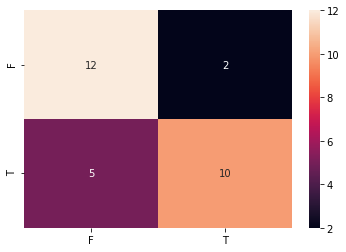

In [61]:
sn.heatmap(matrix, annot=True, xticklabels=['F', 'T'], yticklabels=['F', 'T'])